# Setup, matplotlib inline, automatically reload libraries on every evaluation

In [205]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from creon.loadcreon import LoadCreon, save_search, load_search
from creon.creonsklearn.creonmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer
from creon.semisuperhelper import SemiSupervisedHelper
from creon.creonsklearn.pnuwrapper import PNUWrapper
from creon.creonsklearn.jeffsearchcv import JeffRandomSearchCV, extract_score_grid
from creon.creonsklearn.nestedcross import NestedCV, rerun_nested_for_estimator, rerun_nested_for_scoring
from creon.creonsklearn.frankenscorer import FrankenScorer, extract_scores_from_nested

In [3]:
path = "C:\Data\\010317\membership14_final_0103.txt"
lc = LoadCreon(path)

In [229]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

In [16]:
X_train, X_test, y_train, y_test = train_test_split(lc.X, lc.y, test_size=0.2, random_state=771, stratify=lc.y)

## Set up randomized search parameters

In [209]:
rf_param_search = {'base_estimator__n_estimators':sp.stats.randint(low=10, high=500),
                   'num_unlabeled':sp.stats.randint(low=0, high=15000),
                   'pu_learning':[False, True],
                   'base_estimator__max_features':['sqrt','log2',5, 10, 20, 50, None],
                   #todo - make custom rvs for this type of thing where I want a None some % of the time
                   'base_estimator__max_depth':sp.stats.randint(low=2, high=100),
                   'base_estimator__min_samples_split':[2,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,
                                                        0.045,0.05,0.07,0.09,0.1,0.12,0.15,0.17,0.2,0.25],
                   'base_estimator__min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100],
                   'base_estimator__class_weight':[None,'balanced','balanced_subsample']}

## Set up PNU Wrapper with Random Forest, then JeffSearchCV, then NestedCV

In [21]:
pnu = PNUWrapper(base_estimator=RandomForestClassifier(), random_state=None)

In [211]:
jeffsearch = JeffRandomSearchCV(pnu, rf_param_search, n_iter=40, scoring=FrankenScorer(),
                                n_jobs=-1, cv=5, verbose=100, pre_dispatch=8)

#### 5x5 (x40) nested cross validation

In [212]:
nested_cross = NestedCV(jeffsearch, scoring=FrankenScorer(), cv=5, random_state=None)

## Score the nested cross - 1000 models!

In [213]:
scores = nested_cross.score(X_train.values, y=y_train.values, n_jobs=-1, verbose=100, pre_dispatch=8)

Pickling array (shape=(624,), dtype=uint32).
Memmaping (shape=(352556, 288), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_201792928\5244-200666864-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_201792928\5244-200666864-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(282044,), dtype=int32) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_201792928\5244-200666864-c9c654a2f7eb2665bd3c539dafc8097f.pkl
Pickling array (shape=(70512,), dtype=int32).
Pickling array (shape=(624,), dtype=uint32).
Memmaping (shape=(352556, 288), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_201792928\5244-200666864-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_201

## The scores of the 5 folds of the outer loop.  FrankenScorer by default uses labeled_f1 metric which probably isn't what we want to use for the end result

In [214]:
scores

(0.95601173020527863,
 0.9216589861751151,
 0.95718654434250761,
 0.89677419354838706,
 0.90822784810126567)

In [215]:
save_search(nested_cross, './res/nested_cross_rf_small_20170124')

In [19]:
nested_cross = load_search('./res/nested_cross_rf_small_20170124')

## going to rerun the nested cross with the best estimator of the search from the section below:

In [22]:
best_estimator = clone(pnu)
best_estimator.set_params(**{'base_estimator__class_weight': 'balanced',
  'base_estimator__max_depth': 80,
  'base_estimator__max_features': None,
  'base_estimator__min_samples_leaf': 4,
  'base_estimator__min_samples_split': 0.2,
  'base_estimator__n_estimators': 294,
  'num_unlabeled': 1807,
  'pu_learning': True})

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=4, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, n_estimators=294, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
      num_unlabeled=1807, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [23]:
nested_cross = rerun_nested_for_estimator(nested_cross, best_estimator, X_train.values, y_train.values, n_jobs=-1)

In [24]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean()

labeled_brier                                        0.135725
tp_confusion_matrix_lab                                 270.4
fp_confusion_matrix_un                                   5157
fn_confusion_matrix_lab                                  63.6
labeled_acc                                           0.82701
labeled_avg_prec                                       0.9269
fn_confusion_matrix_un                                   63.6
fp_confusion_matrix_lab                                    24
labeled_prec                                         0.918617
labeled_brier_pos                                    0.111724
tp_confusion_matrix_un                                  270.4
labeled_brier_neg                                    0.182193
pr_one_unlabeled                                    0.0733235
confusion_matrix_un        [[65020.2, 5157.0], [63.6, 270.4]]
tn_confusion_matrix_un                                65020.2
assumed_brier                                       0.0929373
labeled_

## If we extract the nested CV metrics for all 5 folds and take the average, here is what we get across the board.  Now this is what we get if we take the best sub classifiers on "labeled_f1", so notice the 'pu_score'=3.23 which isn't good and 'pr_one_unlabled'=45.5%! We will need to optimize to something else even though the labeled f1 is fantastic...

In [17]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean()

labeled_brier                                        0.136444
tp_confusion_matrix_lab                                   270
fp_confusion_matrix_un                                 5129.6
fn_confusion_matrix_lab                                    64
labeled_acc                                          0.825824
labeled_avg_prec                                     0.926288
fn_confusion_matrix_un                                     64
fp_confusion_matrix_lab                                  24.2
labeled_prec                                         0.917803
labeled_brier_pos                                    0.112678
tp_confusion_matrix_un                                    270
labeled_brier_neg                                    0.182465
pr_one_unlabeled                                    0.0729293
confusion_matrix_un        [[65047.6, 5129.6], [64.0, 270.0]]
tn_confusion_matrix_un                                65047.6
assumed_brier                                       0.0925411
labeled_

## Lets do a validation curve on a high performing random forest model to see how many estimators we need

In [37]:
params = {'base_estimator__class_weight': 'balanced',
  'base_estimator__max_depth': 7,
  'base_estimator__max_features': 50,
  'base_estimator__min_samples_leaf': 2,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimators': 1677,
  'num_unlabeled': 10654,
  'pu_learning': False}
valid_curve_clf = PNUWrapper(RandomForestClassifier())

In [38]:
valid_curve_clf.set_params(**params)

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features=50,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1677, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
      num_unlabeled=10654, pu_learning=False, random_state=None,
      threshold_set_pct=None)

In [39]:
from sklearn.model_selection import validation_curve

In [40]:
param_range=[10, 50, 100, 150, 200, 300, 400, 500, 1000]
train_scores, test_scores = validation_curve(valid_curve_clf, X_train.values, y_train.values, 'base_estimator__n_estimators',
                 param_range=param_range, cv=5, scoring=f1_assumed_beta10_scorer, n_jobs=3, verbose=100)

Memmaping (shape=(352556, 288), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(282044,), dtype=int32) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-c9c654a2f7eb2665bd3c539dafc8097f.pkl
Pickling array (shape=(70512,), dtype=int32).
Memmaping (shape=(352556, 288), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(282044,), dtype=in

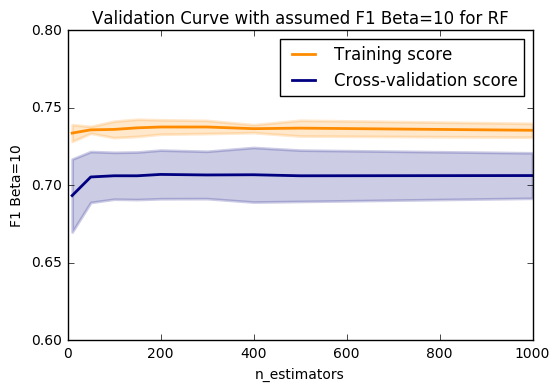

In [45]:
import matplotlib.pyplot as plt
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with assumed F1 Beta=10 for RF")
plt.xlabel("n_estimators")
plt.ylabel("F1 Beta=10")
plt.ylim(0.6, 0.8)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

## Notice the graph above it seems like the cross-val score flattens out at around 100 estimators - so that hyper-parameter may not be that important, which is good for us!

## On another note, notice the gap between training score and cross-validation score, that may represent some level of over-fitting, so in the future we may want to cut down on the number of our features, or try simplifying our models in other ways.  The gap is small though, so it may be a non-issue as well

In [44]:
test_scores_mean

array([ 0.69341837,  0.70541213,  0.70618633,  0.70617558,  0.70705154,
        0.70670984,  0.70684229,  0.70617986,  0.7063227 ])

# Let's rerun the 1000 model search from before using 'assumed_f1beta10' metric

In [157]:
from nestedcross import rerun_nested_for_scoring

In [217]:
next_ness = rerun_nested_for_scoring(nested_cross, 'assumed_f1beta10', X_train.values, y_train.values, 
                                     how='max', n_jobs=-1, verbose=100)

Memmaping (shape=(352556, 288), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_228971072\5244-265952448-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_228971072\5244-265952448-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(282044,), dtype=int32) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_228971072\5244-265952448-c9c654a2f7eb2665bd3c539dafc8097f.pkl
Pickling array (shape=(70512,), dtype=int32).
Memmaping (shape=(352556, 288), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_228971072\5244-265952448-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_228971072\5244-265952448-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(282044,), dty

In [218]:
next_ness.test_scores_

(0.71228536385936214,
 0.72594481799211685,
 0.69625736245740999,
 0.69714153751411256,
 0.71177797140074817)

## Notice above that it took 13 minutes to run a search over 1000 models for a new metric. It only had to fit 5 new models to determine what the new metric would generalize to if using it to optimize a hyperparameter search.

In [18]:
extract_scores_from_nested(next_ness.test_score_datas_).mean()

NameError: name 'next_ness' is not defined

# Let's dive in and see the parameters for one of the best models

In [223]:
scores = extract_score_grid(next_ness.estimators_[2])

In [224]:
scores.mean_assumed_f1beta10_test.idxmax()

32

In [230]:
best_params = next_ness.estimators_[2].cv_results_['params'][32]
best_params

{'base_estimator__class_weight': 'balanced_subsample',
 'base_estimator__max_depth': 66,
 'base_estimator__max_features': None,
 'base_estimator__min_samples_leaf': 10,
 'base_estimator__min_samples_split': 0.005,
 'base_estimator__n_estimators': 363,
 'num_unlabeled': 12593,
 'pu_learning': True}

In [243]:
all_scores = [extract_score_grid(est) for est in next_ness.estimators_]

In [246]:
best_clf_idx = [s.mean_assumed_f1beta10_test.idxmax() for s in all_scores]

In [247]:
[est.cv_results_['params'][best_idx] for est, best_idx in zip(next_ness.estimators_, best_clf_idx)]

[{'base_estimator__class_weight': 'balanced',
  'base_estimator__max_depth': 59,
  'base_estimator__max_features': 50,
  'base_estimator__min_samples_leaf': 4,
  'base_estimator__min_samples_split': 0.01,
  'base_estimator__n_estimators': 131,
  'num_unlabeled': 12517,
  'pu_learning': False},
 {'base_estimator__class_weight': 'balanced',
  'base_estimator__max_depth': 80,
  'base_estimator__max_features': None,
  'base_estimator__min_samples_leaf': 4,
  'base_estimator__min_samples_split': 0.2,
  'base_estimator__n_estimators': 294,
  'num_unlabeled': 1807,
  'pu_learning': True},
 {'base_estimator__class_weight': 'balanced_subsample',
  'base_estimator__max_depth': 66,
  'base_estimator__max_features': None,
  'base_estimator__min_samples_leaf': 10,
  'base_estimator__min_samples_split': 0.005,
  'base_estimator__n_estimators': 363,
  'num_unlabeled': 12593,
  'pu_learning': True},
 {'base_estimator__class_weight': 'balanced',
  'base_estimator__max_depth': 54,
  'base_estimator__max

## Below is that specific model's test set scores in the inner loop.  These can't really be used in any comparison since they are biased but interesting to see.  Notice PU-score of 10.45, recall 0.8, precicion 0.92, pr_one_unlabeled = 5.84%.

In [226]:
scores.iloc[32][[c for c in scores.columns if 'test' in c and 'mean' in c]]

mean_labeled_f1_test                  0.859097
mean_labeled_recall_test              0.806113
mean_labeled_acc_test                 0.825762
mean_fp_confusion_matrix_lab_test         18.8
mean_labeled_brier_test               0.143333
mean_fn_confusion_matrix_un_test          51.8
mean_tp_confusion_matrix_lab_test        215.4
mean_tp_confusion_matrix_un_test         215.4
mean_tn_confusion_matrix_lab_test        119.2
mean_confusion_matrix_lab_test             NaN
mean_assumed_f1_test                  0.114144
mean_labeled_brier_neg_test           0.138661
mean_confusion_matrix_un_test              NaN
mean_assumed_f1beta10_test            0.719595
mean_labeled_prec_test                0.920053
mean_tn_confusion_matrix_un_test       52847.4
mean_labeled_roc_auc_test              0.83494
mean_assumed_brier_test              0.0532553
mean_pu_score_test                     10.4511
mean_labeled_brier_pos_test           0.145761
mean_fn_confusion_matrix_lab_test         51.8
mean_assumed_

In [189]:
extract_scores_from_nested(next_ness.test_score_datas_).mean()

fn_confusion_matrix_lab                                  62.4
tn_confusion_matrix_un                                64991.6
labeled_roc_auc                                      0.796337
confusion_matrix_lab           [[134.4, 38.0], [62.4, 271.6]]
labeled_acc                                          0.801717
confusion_matrix_un        [[64991.6, 5185.6], [62.4, 271.6]]
labeled_brier_neg                                    0.179147
labeled_prec                                         0.880482
fn_confusion_matrix_un                                   62.4
assumed_brier                                       0.0756377
assumed_brier_neg                                   0.0753697
labeled_brier_pos                                    0.131953
labeled_recall                                       0.813174
assumed_f1                                          0.0938105
fp_confusion_matrix_lab                                    38
assumed_f1beta10                                     0.705947
tp_confu

## Let's see what feature importance looks like for this specific estimator

In [235]:
best_clf = clone(next_ness.estimators_[2].estimator).set_params(**best_params)

In [236]:
best_clf.fit(X_train.values, y_train.values)

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=66, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=0.005,
            min_weight_fraction_leaf=0.0, n_estimators=363, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
      num_unlabeled=12593, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [237]:
FrankenScorer()(best_clf, X_test.values, y_test.values)

({'SCORE': 0.84653465346534651,
  'assumed_brier': 0.057540639553026629,
  'assumed_brier_neg': 0.057233791695435653,
  'assumed_f1': 0.10958026273630246,
  'assumed_f1beta10': 0.72530656811691596,
  'confusion_matrix_lab': array([[167,  48],
         [ 76, 342]]),
  'confusion_matrix_un': array([[82240,  5482],
         [   76,   342]]),
  'labeled_acc': 0.80410742496050558,
  'labeled_avg_prec': 0.90758404312906693,
  'labeled_brier': 0.1442279224653652,
  'labeled_brier_neg': 0.18756734801773578,
  'labeled_brier_pos': 0.12193611267168178,
  'labeled_f1': 0.84653465346534651,
  'labeled_prec': 0.87692307692307692,
  'labeled_recall': 0.81818181818181823,
  'labeled_roc_auc': 0.79746300211416499,
  'pr_one_unlabeled': 0.062097889311712208,
  'pu_score': 10.130976977567888},
 0.84653465346534651)

In [238]:
pd.DataFrame(best_clf.base_estimator.feature_importances_, index=X_test.columns).sort_values(by=0, ascending=False)

,0
DIAG_FLAG4_Sum,4.955561e-01
DIAG_FLAG5_Sum,2.300625e-01
ndc_cat58_Sum,3.582271e-02
DIAG_FLAG6_Sum,1.878767e-02
age,1.127403e-02
CPT_FLAG43_Sum,7.254220e-03
ndc_cat87_Sum,6.721163e-03
CPT_FLAG48_Sum,6.645633e-03
ndc_cat85_Sum,5.333897e-03
DIAG_FLAG41_Sum,5.151010e-03


# Quick side-project - lets test how using every sample in RF would work

In [190]:
params = {'base_estimator__class_weight': 'balanced',
 'base_estimator__max_depth': 48,
 'base_estimator__max_features': None,
 'base_estimator__min_samples_leaf': 10,
 'base_estimator__min_samples_split': 0.15,
 'base_estimator__n_estimators': 56,
 'num_unlabeled': 8303,
 'pu_learning': True}

In [191]:
pnu.set_params(**params)

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=48, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=0.15,
            min_weight_fraction_leaf=0.0, n_estimators=56, n_jobs=-1,
            oob_score=False, random_state=None, verbose=100,
            warm_start=False),
      num_unlabeled=8303, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [192]:
pnu.set_params(num_unlabeled=1.0, base_estimator__n_jobs=-1, base_estimator__verbose=100)

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=48, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=0.15,
            min_weight_fraction_leaf=0.0, n_estimators=56, n_jobs=-1,
            oob_score=False, random_state=None, verbose=100,
            warm_start=False),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [193]:
pnu.fit(X_train.values, y_train.values)

building tree 1 of 56
building tree 2 of 56building tree 3 of 56

building tree 4 of 56
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   43.0s
building tree 5 of 56
building tree 6 of 56[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min

building tree 7 of 56[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.5min

building tree 8 of 56[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.6min

building tree 9 of 56[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.0min

building tree 10 of 56[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.5min

building tree 11 of 56[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  3.2min

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.2min
building tree 12 of 56
building tree 13 of 56[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.4min

building tree 14 of 56[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min

[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  4.0min
build

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=48, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=0.15,
            min_weight_fraction_leaf=0.0, n_estimators=56, n_jobs=-1,
            oob_score=False, random_state=None, verbose=100,
            warm_start=False),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [194]:
FrankenScorer()(pnu, X_test.values, y_test.values)

[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Do

({'SCORE': 0.85750315258511978,
  'assumed_brier': 0.091195101702102765,
  'assumed_brier_neg': 0.091114022714035986,
  'assumed_f1': 0.095720720720720714,
  'assumed_f1beta10': 0.70824567916511982,
  'confusion_matrix_lab': array([[180,  35],
         [ 78, 340]]),
  'confusion_matrix_un': array([[81376,  6346],
         [   78,   340]]),
  'labeled_acc': 0.82148499210110582,
  'labeled_avg_prec': 0.92164327233421772,
  'labeled_brier': 0.14535843324231648,
  'labeled_brier_neg': 0.21758104530099154,
  'labeled_brier_pos': 0.10821043900161041,
  'labeled_f1': 0.85750315258511978,
  'labeled_prec': 0.90666666666666662,
  'labeled_recall': 0.8133971291866029,
  'labeled_roc_auc': 0.82530321575609211,
  'pr_one_unlabeled': 0.072119944690139076,
  'pu_score': 8.7219168986300168},
 0.85750315258511978)

## Hmmm - lets do a validation curve on this - I think it caps out at around 10,000 unlabeled

In [195]:
param_range=[0,500,1000,2000,5000,7500,10000,15000]
train_scores, test_scores = validation_curve(pnu, X_train.values, y_train.values, 'num_unlabeled',
                 param_range=param_range, cv=3, scoring=f1_assumed_beta10_scorer, n_jobs=-1, verbose=100)

Pickling array (shape=(1,), dtype=int64).
Pickling array (shape=(39,), dtype=[('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]).
Pickling array (shape=(39, 1, 2), dtype=float64).
Pickling array (shape=(2,), dtype=float64).
Pickling array (shape=(1,), dtype=int64).
Pickling array (shape=(61,), dtype=[('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]).
Pickling array (shape=(61, 1, 2), dtype=float64).
Pickling array (shape=(2,), dtype=float64).
Pickling array (shape=(1,), dtype=int64).
Pickling array (shape=(69,), dtype=[('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]).
Pickling array (shape=(69, 1, 2), dtype=float64).
Pic

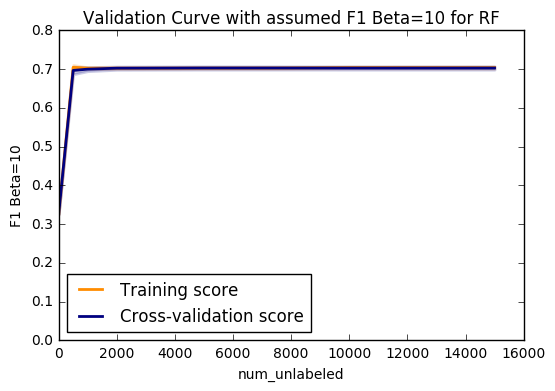

In [197]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with assumed F1 Beta=10 for RF")
plt.xlabel("num_unlabeled")
plt.ylabel("F1 Beta=10")
plt.ylim(0.0, 0.8)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()